# CPSC 330 Lecture 11

#### Lecture plan

- Announcements
- Left over material from last class: a comment on `class_weight` and `predict_proba`
- Left over material from last class: stratified splits (5 min)
- Left over material from last class: hyperparameter optimization (15 min)
- Left over material from last class: summary (5 min)
- Break (5 min)
- Data set of the week (20 min)
- Transforming the targets (15 min)
- T/F questions (15 min)

In [429]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import tree 
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, r2_score, mean_squared_error
from sklearn.linear_model import Ridge

In [179]:
from pandas_profiling import ProfileReport

In [180]:
plt.rcParams['font.size'] = 16

In [181]:
def show_scores(model, X_train, y_train, X_valid, y_valid):
    print("Training score: %.4f" % model.score(X_train, y_train))
    print("Test     score: %.4f" % model.score(X_valid, y_valid))

## Announcements

- hw4 released, due Sunday at 6pm.
- Midterm next week Thursday, Feb 13, at 11:05am in our usual classroom.
  - Midterm will cover material up to the break in today's lecture (i.e. lectures notebooks 1-8) and/or hw1-hw4.
  - Midterm will not cover the 2nd half of today's lecture, or any further material between now and then. 
  - Per [here](https://github.students.cs.ubc.ca/cpsc330-2019w-t2/home/blob/master/docs/course_info.md#midterm) you are allowed one double-sided sheet of notes.

## Data set of the week (20 min)

This week in lecture we will be focussing on the [Kaggle House Prices dataset](https://www.kaggle.com/c/home-data-for-ml-course/). As usual, to run this notebook you'll need to download the data. Unzip the data into a subdirectory called `data/week_05_house-prices`. For this dataset, train and test have already been separated. 

In [182]:
df_train = pd.read_csv("data/week_05_house-prices/train.csv")

In [183]:
df_train, df_test = train_test_split(df_train, test_size=0.1, random_state=123)

In [184]:
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=123)

In [185]:
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
1341  1342          20       RL         66.0    13695   Pave   NaN      Reg   
459    460          50       RL          NaN     7015   Pave   NaN      IR1   
367    368          80       RL        101.0     9150   Pave   NaN      IR1   
894    895          90       RL         64.0     7018   Pave   NaN      Reg   
672    673          20       RL          NaN    11250   Pave   NaN      IR1   

     LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal  \
1341         Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
459          Bnk    AllPub  ...        0    NaN   NaN         NaN       0   
367          Lvl    AllPub  ...        0    NaN   NaN         NaN       0   
894          Bnk    AllPub  ...        0    NaN   NaN         NaN       0   
672          Lvl    AllPub  ...        0    NaN   NaN         NaN       0   

     MoSold YrSold  SaleType  SaleCondition  SalePrice  
1341      7   2008        WD         Normal     155000  
459       7   2009        WD         Normal     110000  
367      12   2008        WD         Normal     165000  
894       6   2009        WD         Alloca     118858  
672       6   2006        WD         Normal     165000  

[5 rows x 81 columns]

- Here, the target is `SalePrice`. Note that this is numeric, not categorical.
- In this case, we call the task **regression** (as opposed to classification).

In [186]:
df_train.shape

(1051, 81)

In [ ]:
# df_train.info()

#### Step 1: `pandas_profiler`

In [ ]:
profile = ProfileReport(df_train, title='Pandas Profiling Report') #, minimal=True)

In [83]:
profile.to_notebook_iframe()

- From here we can see a mix of feature types, and a bunch of missing values. 
- Now, I do some of the dirty work...
- There are a bunch of ordinal features using the same scale: excellent, good, average, etc.
  - These I'm calling `ordinal_features_reg`.
- There are a bunch more ordinal features using different scales.
  - These I'm calling `ordinal_features_oth`
  - To save time I'm ignoring the ordinality and just encoding them as categorical.

In [343]:
target               = ['SalePrice']
drop_features        = ['Id']
numeric_features     = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 
                        'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 
                        'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 
                        'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                        'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 
                        'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
                        'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold']
ordinal_features_reg = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                        'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
ordinal_features_oth = ['BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
                        'Functional',  'Fence']
categorical_features = list(set(df_train.columns) - set(target) - set(drop_features) - 
                            set(numeric_features) - 
                            set(ordinal_features_reg) - set(ordinal_features_oth))
all_features = numeric_features + ordinal_features_reg + categorical_features + ordinal_features_oth

ordering = ['Po', 'Fa', 'TA', 'Gd', 'Ex'] # if N/A it will just impute something, per below

#### Step 2: data quality

- We'll just use `SimpleImputer` again.
- In reality we'd want to go through this more carefully.
- We may also want to drop some columns that are almost entirely missing.
- We could also check for outliers, and do other EDA.

In [344]:
imputers = [
    ('numeric', SimpleImputer(strategy='median'), numeric_features),
    ('ordinal', SimpleImputer(strategy='most_frequent'), ordinal_features_reg),
    ('categor', SimpleImputer(strategy='constant', fill_value="?"), 
     categorical_features + ordinal_features_oth)]
# NOTE: the order here must match the order of all_features

In [345]:
impute_transformer = ColumnTransformer(transformers=imputers)

In [346]:
impute_transformer.fit(df_train);

In [347]:
df_train_imp = pd.DataFrame(impute_transformer.transform(df_train), index=df_train.index, columns=all_features)
df_valid_imp = pd.DataFrame(impute_transformer.transform(df_valid), index=df_valid.index, columns=all_features)
df_test_imp  = pd.DataFrame(impute_transformer.transform(df_test),  index=df_test.index,  columns=all_features)

In [348]:
df_train_imp.head()

LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd  \
1341          66   13695           6           5      2003         2004   
459           69    7015           5           4      1950         1950   
367          101    9150           6           5      1962         1962   
894           64    7018           5           5      1979         1979   
672           69   11250           6           6      1977         1977   

     MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF  ... MoSold Foundation Street  \
1341          0        814          0       300  ...      7      PConc   Pave   
459         161        185          0       524  ...      7     CBlock   Pave   
367         305        371          0       728  ...     12     CBlock   Pave   
894           0          0          0         0  ...      6       Slab   Pave   
672           0        767          0       441  ...      6     CBlock   Pave   

     LotConfig LotShape BsmtExposure BsmtFinType1 BsmtFinType2 Functional  \
1341    Inside      Reg           No          GLQ          Unf        Typ   
459     Corner      IR1           No          LwQ          Unf        Typ   
367     Corner      IR1           Gd          GLQ          Unf        Typ   
894     Inside      Reg            ?            ?            ?        Typ   
672     Inside      IR1           No          ALQ          Unf        Typ   

     Fence  
1341     ?  
459      ?  
367      ?  
894      ?  
672      ?  

[5 rows x 79 columns]

#### Step 3: feature transformations

In [349]:
feature_transformers = [
    ('scale',  StandardScaler(), numeric_features),
    ('ord',    OrdinalEncoder(categories=[ordering for i in ordinal_features_reg]), ordinal_features_reg),
    ('ohe',    OneHotEncoder(drop='first', sparse=False), categorical_features + ordinal_features_oth) ]

In [350]:
feature_preprocessor = ColumnTransformer(transformers=feature_transformers)

In [351]:
feature_preprocessor.fit(df_train_imp);

In [352]:
new_columns = numeric_features + ordinal_features_reg + list(feature_preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features + ordinal_features_oth))
new_columns;
# NOTE: the order here must match the order above

In [353]:
df_train_imp_encode = pd.DataFrame(feature_preprocessor.transform(df_train_imp), index=df_train_imp.index, columns=new_columns)
df_valid_imp_encode = pd.DataFrame(feature_preprocessor.transform(df_valid_imp), index=df_valid_imp.index, columns=new_columns)
df_test_imp_encode  = pd.DataFrame(feature_preprocessor.transform(df_test_imp),  index=df_test_imp.index,  columns=new_columns)

ValueError: Found unknown categories ['Blueste'] in column 1 during transform

What happened here?

- We fit the `OneHotEncoder` on the training data.
- Due to the splits, none of the training examples had these categories, but the validation/test set has them.
- How do we want to handle this? 
- It depends!
- Option 1: fit the OHE on _all_ data.
  - But isn't this violating the Golden Rule??
  - Well, do we know the categories in advance?
  - Or is there a chance we'll see a new category in deployment? 
- Option 2: have a special category for "unknown".
  - We can reserve all zeros, but then we can't drop the first.
  - Let's do Option 2, to be safe.

In [356]:
feature_transformers = [
    ('scale',  StandardScaler(), numeric_features),
    ('ord',    OrdinalEncoder(categories=[ordering for i in ordinal_features_reg]), ordinal_features_reg),
    # note changes           VVVVVVVVVV       and     VVVVVVVVVVVVVVVVVVVVVVV
    ('ohe',    OneHotEncoder(drop=None, sparse=False, handle_unknown='ignore'), categorical_features + ordinal_features_oth)]

In [357]:
feature_preprocessor = ColumnTransformer(transformers=feature_transformers)

In [358]:
feature_preprocessor.fit(df_train_imp);

In [359]:
new_columns = numeric_features + ordinal_features_reg + list(feature_preprocessor.named_transformers_['ohe'].get_feature_names(categorical_features + ordinal_features_oth))
new_columns;

In [360]:
X_train_imp_encode = feature_preprocessor.transform(df_train_imp)
X_valid_imp_encode = feature_preprocessor.transform(df_valid_imp)
X_test_imp_encode  = feature_preprocessor.transform(df_test_imp)

df_train_imp_encode = pd.DataFrame(X_train_imp_encode, index=df_train_imp.index, columns=new_columns)
df_valid_imp_encode = pd.DataFrame(X_valid_imp_encode, index=df_valid_imp.index, columns=new_columns)
df_test_imp_encode  = pd.DataFrame(X_test_imp_encode,  index=df_test_imp.index,  columns=new_columns)

In [361]:
y_train = df_train["SalePrice"]
y_valid = df_valid["SalePrice"]
y_test  = df_test["SalePrice"]

In [362]:
new_columns

['LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'YrSold',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'HeatingQC',
 'KitchenQual',
 'FireplaceQu',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Heating_Floor',
 'Heating_GasA',
 'Heating_GasW',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edwards',
 'Neighborhood_Gilbert',
 'Neighborhood_IDOTRR',
 'Neighborhood_MeadowV',
 'Neighborhood_Mitchel',
 'Neigh

In [363]:
X_train_imp_encode.shape

(1051, 288)

#### Step 4: `DummyRegressor`

In [364]:
dummy = DummyRegressor()
dummy.fit(X_train_imp_encode, y_train);

In [365]:
dummy.score(X_train_imp_encode, y_train)

0.0

In [366]:
dummy.score(X_valid_imp_encode, y_valid)

-0.022671203022716302

Wait, a negative score??

## Regression score functions: mean squared error and R^2 (15 min)

We aren't doing classification anymore, so we can't just check for equality:

In [367]:
dummy.predict(X_train_imp_encode) == y_train

1341    False
459     False
367     False
894     False
672     False
        ...  
342     False
1447    False
1365    False
886     False
312     False
Name: SalePrice, Length: 1051, dtype: bool

In [368]:
dummy.predict(X_train_imp_encode)

array([181790.28829686, 181790.28829686, 181790.28829686, ...,
       181790.28829686, 181790.28829686, 181790.28829686])

In [369]:
y_train.values

array([155000, 110000, 165000, ..., 216000, 145000, 119900])

- We need a score that reflect how right/wrong each prediction is.

#### Mean squared error (MSE)

A common measure is mean squared error:

In [370]:
preds = dummy.predict(X_train_imp_encode)

In [371]:
np.mean((y_train - preds)**2)

6696134070.580063

This is also implemented in sklearn:

In [372]:
mean_squared_error(y_train, preds)

6696134070.580063

- Perfect predictions would have MSE=0. 

In [373]:
mean_squared_error(y_train, y_train)

0.0

- But is the above score good or bad? 
  - It depends on the scale of the targets.
  - If we were working in cents instead of dollars, our MSE would be 10,000x ($100^2$) higher!

In [374]:
np.mean((y_train*100 - preds*100)**2)

66961340705800.63

- A common score is the $R^2$. 
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: mean squared error, but flipped (higher is better), and normalized so the max is 1.
- Key points:
  - The maximum is 1 for perfect predictions
  - Negative values are very bad: "worse than `DummyRegressor`" (very bad)

In [375]:
r2_score(y_train, preds)

0.0

In [376]:
r2_score(y_train, y_train)

1.0

In [377]:
r2_score(y_valid, dummy.predict(X_valid_imp_encode))

-0.022671203022716302

This is the score that sklearn uses by default when you call `score()`:

In [378]:
dummy.score(X_train_imp_encode, y_train)

0.0

In [379]:
dummy.score(X_valid_imp_encode, y_valid)

-0.022671203022716302

(optional) Warning: MSE is "reversible" but $R^2$ is not:

In [380]:
mean_squared_error(y_train, preds)

6696134070.580063

In [381]:
mean_squared_error(preds, y_train)

6696134070.580063

In [382]:
r2_score(y_train, preds)

0.0

In [383]:
r2_score(preds, y_train)

-7.905399774927193e+30

- When you call `fit` it minimizes MSE / maximizes $R^2$ by default.
- Just like in classification, this isn't always what you want!!
- More on this later.

## Transforming the targets (15 min)

Let's try something more serious than `DummyRegressor`:

In [405]:
rf = RandomForestRegressor(random_state=111)
rf.fit(X_train_imp_encode, y_train);

In [406]:
rf.score(X_train_imp_encode, y_train)

0.9792071509359096

In [407]:
rf.score(X_valid_imp_encode, y_valid)

0.8489382516000105

In [408]:
mse_valid = mean_squared_error(y_valid, rf.predict(X_valid_imp_encode))
mse_valid

657435857.0555309

- In this case, we are actually interested in the original units of dollars.
- MSE is in units of "squared dollars"
- We can take the square root of the this to get back to dollars:

In [409]:
rmse_valid = np.sqrt(mse_valid)
rmse_valid

25640.512027951605

So, on average we're off by about \$25000. Is this good?

<br><br><br><br><br><br>

- For a house worth \\$500k, it seems reasonable! That's 5% error.
- For a house worth \\$50k, that is terrible. It's 50% error.

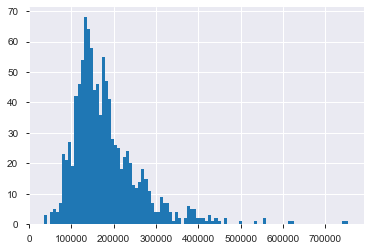

In [410]:
plt.hist(y_train, bins=100);

- Indeed, we have both of these cases in our dataset.
- Can we compute percent error?

In [411]:
pred_train = rf.predict(X_train_imp_encode)
pred_valid = rf.predict(X_valid_imp_encode)

In [412]:
percent_errors = (pred_train - y_train)/y_train
percent_errors

1341   -0.000851
459     0.048076
367    -0.022197
894     0.021336
672    -0.009855
          ...   
342     0.016602
1447    0.080888
1365   -0.019517
886     0.052484
312     0.025338
Name: SalePrice, Length: 1051, dtype: float64

- These are both positive (predict too high) and negative (predict too low).
- We can look at the absolute percent error:

In [413]:
np.abs(percent_errors)

1341    0.000851
459     0.048076
367     0.022197
894     0.021336
672     0.009855
          ...   
342     0.016602
1447    0.080888
1365    0.019517
886     0.052484
312     0.025338
Name: SalePrice, Length: 1051, dtype: float64

And, like MSE, we can take the average over examples. This is called **mean absolute percent error (MAPE)**.

In [430]:
def mape(true, pred):
    return 100.*np.mean(np.abs((pred - true)/true))

In [431]:
mape(y_train, pred_train)

3.8548167866370076

In [432]:
mape(y_valid, pred_valid)

11.096627868989174

- Ok, this is quite interpretable.
- On average, we have 11% error. Good to know. 

- ... but wait a minute, why are we minimizing MSE if we care about MAPE??
- When minimizing MSE, **the expensive houses will dominate** because they have the biggest error.
- The model would rather do \\$50 k worse on a cheap place and \\$60k better on an expensive place.
  - But this would make the MAPE much worse!
- Key idea: **log transform the targets**.
  - That is, transform $y\rightarrow \log(y)$.
- Why?
- Let's assume we have two values, the prediction and the true value.
- We log transform them and look at the squared error:

$$\begin{align}(\log y_\text{pred} - \log y_\text{true})^2 =\left(\log \frac{y_\text{pred}}{y_\text{true}}\right)^2  \end{align}$$

But what is the absolute percent error? It is

$$\left| \frac{y_\text{pred} - y_\text{true}}{y_\text{true}} \right| = \left| \frac{y_\text{pred}}{y_\text{true}} -1 \right|$$

This is a bit hand-wavy (and maybe I'll nail this down later), but for now: both are minimized (equal to zero) when $\frac{y_\text{pred}}{y_\text{true}}=1$, so both are trying to make $\frac{y_\text{pred}}{y_\text{true}}$ close to $1$.

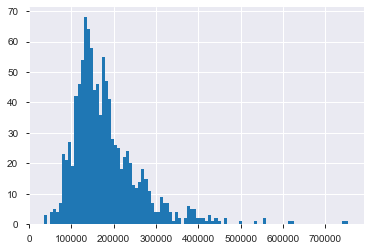

In [417]:
plt.hist(y_train, bins=100);

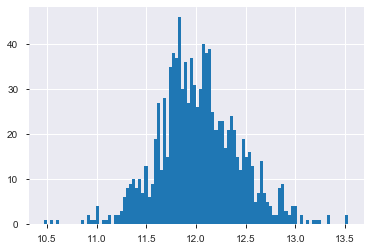

In [418]:
plt.hist(np.log(y_train), bins=100);

In [419]:
rf_log = RandomForestRegressor(random_state=111)
rf_log.fit(X_train_imp_encode, np.log(y_train));

In [420]:
rf_log.predict(X_train_imp_encode)

array([11.93984001, 11.64752271, 11.97487211, ..., 12.26414513,
       11.94306799, 11.72388774])

These are log predictions. We can `exp` them to get back to dollars:

In [421]:
pred_train_log_exp = np.exp(rf_log.predict(X_train_imp_encode))
pred_valid_log_exp = np.exp(rf_log.predict(X_valid_imp_encode))

In [422]:
pred_train_log_exp

array([153252.1701315 , 114407.59064316, 158716.06180317, ...,
       211958.361911  , 153747.66307686, 123486.57685581])

How is the MSE on the training set?

In [423]:
mean_squared_error(pred_train, y_train) # ORIGINAL model

139231705.0424844

In [424]:
mean_squared_error(pred_train_log_exp, y_train) # log transformed training

146884324.8543725

- The MSE got worse
  - That makes sense because we're no longer optimizing for MSE.
- Let's look at the MAPE.

In [433]:
mape(y_train, pred_train)

3.8548167866370076

In [434]:
mape(y_train, pred_train_log_exp)

3.745600758589586

- The MAPE got better!
- We can do the same for the validation set:

In [435]:
mape(y_valid, pred_valid)

11.096627868989174

In [436]:
mape(y_valid, pred_valid_log_exp)

10.579486066398703

- Here we get a small benefit, but it could be very large in some cases.
- Also, the model's interpretation can often be better in the log transformed case.
- For linear regression: 
  - 1 more bedroom increases price by \\$50K vs
  - 1 more bedroom increases price by 5%.


- Note that this assumes the $y$-values are positive, which is true in this case.
  - There is still a problem if one of the $y$-values is zero, so it's common to do $\log(1+y)$ instead of $\log(y)$.
  - There is even a numpy function to do this for you: [`log1p`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.log1p.html) (better handing of floating point issues for small numbers -- not too relevant to us here).

## True/False questions (15 min)

1. In classification, `class_weight` should be used when you have severely imbalanced classes.
2. In skopt `BayesSearchCV`, the next experiment depends on the results of the previous experiments.
3. In regression, one should use MAPE instead of MSE when relative (percent) error matters more than absolute error.
4. In regression, when some of our target values are much bigger than others, we should log transform our targets. 